In [36]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [37]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
def saveText(fPath, arr):
    dim1, dim2 = arr.shape
    f = open(fPath, 'a')
    np.savetxt(f, arr.flatten(), newline = ', ')
    f.write("\n")
    f.close()

In [42]:
#have to change with different number of layers
def params_init():

  #np.random.seed(2)
  W1 = np.random.rand(500,784) - 0.5
  b1 = np.random.rand(500,1) - 0.5
  W2 = np.random.rand(500,500) - 0.5
  b2 = np.random.rand(500,1) - 0.5
  W3 = np.random.rand(10,500) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr, factor=0):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descent(X,Y,iter, lr, print_op=1, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0


    #storing the weights:
    start = time.time()
    basePath = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\"
    saveText(basePath+"W1.txt", W1)
    saveText(basePath+"W2.txt", W2)
    saveText(basePath+"W3.txt", W3)
    saveText(basePath+"b1.txt", b1)
    saveText(basePath+"b2.txt", b2)
    saveText(basePath+"b3.txt", b3)
    end = time.time()
    print("###Saving weights : {time}".format(time = end - start))


    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights




def grad_descent(X,Y,iter, lr, print_op, decay_factor=0):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0
    X1, Y1 = X.T, Y
    X1 = X1.T #take transpose to match the sizes

    Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

    dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)

    W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr, factor = decay_factor)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights


def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/Y.shape[0]*100


In [43]:
W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,100, 0.01,1)

Params Initialised
###Saving weights : 2.1587517261505127
Iteration: 1
Train accuracy: 82.6
Val accuracy: 81.98571428571428
###Saving weights : 2.204078197479248
Iteration: 2
Train accuracy: 86.66507936507936
Val accuracy: 85.67142857142858
###Saving weights : 2.311230182647705
Iteration: 3
Train accuracy: 88.46190476190476
Val accuracy: 87.18571428571428
###Saving weights : 2.3825206756591797
Iteration: 4
Train accuracy: 89.57301587301588
Val accuracy: 88.1
###Saving weights : 4.922435760498047
Iteration: 5
Train accuracy: 90.45238095238095
Val accuracy: 88.57142857142857
###Saving weights : 4.6862287521362305
Iteration: 6
Train accuracy: 91.08730158730158
Val accuracy: 89.05714285714285
###Saving weights : 4.066746950149536
Iteration: 7
Train accuracy: 91.6920634920635
Val accuracy: 89.34285714285714
###Saving weights : 2.1148321628570557
Iteration: 8
Train accuracy: 92.12380952380951
Val accuracy: 90.04285714285714
###Saving weights : 2.07637095451355
Iteration: 9
Train accuracy: 92

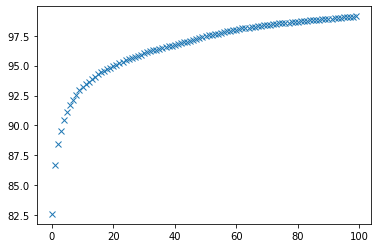

In [46]:
plt.plot(train_acc, 'x')

In [65]:
def loadFromLine(line, shape):
    #line = "xx, xxx, x,....., "
    lineElements = np.array([float(x) for x in line.split(", ")[:-1]]).reshape(shape)
    return lineElements

In [69]:
basePathTest = "D:\\perturbation_on_chip_learning\\Perturbation-techniques-in-CNNs\\weights\\test.txt"
arr = np.random.randint(1, 30000, (1000, 1000))+0.1234
saveText(basePathTest, arr)

In [71]:
ff = open(basePathTest)
for line in ff:
    start = time.time()
    print(loadFromLine(line, (1000,1000)))
    end = time.time()
    print(end-start)
ff.close()

[[14305.1234  5509.1234 29442.1234 ...  3399.1234 16239.1234 24502.1234]
 [13581.1234  4259.1234 15433.1234 ... 29485.1234 21327.1234  9006.1234]
 [15492.1234 28407.1234 15597.1234 ...  7927.1234  6704.1234 24827.1234]
 ...
 [10950.1234  5683.1234 26154.1234 ... 17928.1234  3324.1234  3376.1234]
 [ 9744.1234 22710.1234  2449.1234 ...  3370.1234  3109.1234   212.1234]
 [11699.1234  8407.1234  2663.1234 ...  7898.1234  4009.1234 17086.1234]]
0.546917200088501
